<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


<h1><center>Final Assignment</center></h1>


> ***Note: Please ensure you follow the instructions outlined in the in the <a href="https://www.coursera.org/learn/supervised-machine-learning-regression/supplement/YGZt9/project-scenario">Project Scenario</a> section to complete this Final Assignment successfully.***


# **Imports & Setup**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, TruncatedSVD, KernelPCA, NMF
from sklearn.manifold import MDS
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# **A. Data Summary**
In this step, we used the kagglehub library to automatically download the dataset named “customer-clustering” from Kaggle. The try block ensures that the process runs safely, and if an error occurs (such as no internet access or missing Kaggle API credentials), the code switches to a fallback option, loading a local file named customers.csv. This approach helps maintain workflow continuity without interruption.

The downloaded files include “segmentation data.csv” and “segmentation data legend.xlsx”. The main dataset for analysis is the CSV file, while the Excel file likely contains variable descriptions or legends. After identifying the CSV file, it was loaded into a Pandas DataFrame using pd.read_csv() for further analysis.

The dataset was successfully loaded, containing 2000 rows and 8 columns. The columns are as follows:
['ID', 'Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size'].

Each row represents an individual customer, and the attributes describe their demographic and socioeconomic characteristics. For instance, ‘Age’ and ‘Income’ are numerical features, while ‘Sex’, ‘Marital status’, and ‘Occupation’ are categorical.

In [2]:
try:
    import kagglehub
    # Download latest version
    path = kagglehub.dataset_download("dev0914sharma/customer-clustering")
    print("Path to dataset files:", path)
    # The dataset usually has a file named customers.csv or similar; search
    files = os.listdir(path)
    print("Files in dataset folder:", files)
    # Heuristic: pick first csv
    csv_files = [f for f in files if f.endswith('.csv')]
    if len(csv_files) == 0:
        raise FileNotFoundError("No CSV in downloaded path. Please set data path manually.")
    data_path = os.path.join(path, csv_files[0])
except Exception as e:
    print("kagglehub download failed or not available:", e)
    # fallback: expect user has placed the CSV in working directory named 'customers.csv'
    data_path = "customers.csv"
    print("Using fallback data_path =", data_path)

# Load dataset
df = pd.read_csv(data_path)
print("Loaded dataframe shape:", df.shape)
print("Columns:", df.columns.tolist())

100%|██████████| 25.9k/25.9k [00:00<00:00, 30.4MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/dev0914sharma/customer-clustering/versions/1
Files in dataset folder: ['segmentation data legend.xlsx', 'segmentation data.csv']
Loaded dataframe shape: (2000, 8)
Columns: ['ID', 'Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']


## **1. Data**
We began by loading the dataset and displaying the first five rows to understand its overall structure. The dataset contains 2,000 records and 8 columns, which represent customer demographic and socioeconomic attributes. The columns include an ID field that uniquely identifies each customer, as well as variables such as Sex, Marital status, Age, Education, Income, Occupation, and Settlement size. The data types output shows that all columns are numeric (int64), which means there are no string or categorical data types to encode at this stage.

In [5]:
print("first 5 rows:")
df.head()

first 5 rows:


,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1


We verified missing values across all columns, and the result shows that there are no missing entries in the dataset. This is important because it means we do not need to apply imputation or row deletion, ensuring that all 2,000 observations are complete and ready for analysis.

In [6]:
print("\nData types and missing values:")
df.info()


Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               2000 non-null   int64
 1   Sex              2000 non-null   int64
 2   Marital status   2000 non-null   int64
 3   Age              2000 non-null   int64
 4   Education        2000 non-null   int64
 5   Income           2000 non-null   int64
 6   Occupation       2000 non-null   int64
 7   Settlement size  2000 non-null   int64
dtypes: int64(8)
memory usage: 125.1 KB


In [7]:
print("\nMissing values per column:")
df.isnull().sum()


Missing values per column:


,0
ID,0
Sex,0
Marital status,0
Age,0
Education,0
Income,0
Occupation,0
Settlement size,0


Next, we examined the basic descriptive statistics. The Age column ranges from 18 to 76, indicating a wide representation across different age groups. The average age is about 36 years, suggesting that the dataset mostly consists of young to middle-aged adults. The Income variable ranges from 35,832 to 309,364 USD, with a mean around 120,954 USD and a relatively high standard deviation (38,109), showing large income variability among customers. The Education, Occupation, and Settlement size columns are encoded as integers with small ranges, confirming that they are categorical variables represented numerically. Overall, the data appears clean, well-structured, and suitable for clustering after appropriate scaling and encoding.

In [8]:
print("\nBasic descriptive stats for numeric columns:")
print(df.describe().T)


Basic descriptive stats for numeric columns:
                  count          mean           std          min  \
ID               2000.0  1.000010e+08    577.494589  100000001.0   
Sex              2000.0  4.570000e-01      0.498272          0.0   
Marital status   2000.0  4.965000e-01      0.500113          0.0   
Age              2000.0  3.590900e+01     11.719402         18.0   
Education        2000.0  1.038000e+00      0.599780          0.0   
Income           2000.0  1.209544e+05  38108.824679      35832.0   
Occupation       2000.0  8.105000e-01      0.638587          0.0   
Settlement size  2000.0  7.390000e-01      0.812533          0.0   

                          25%          50%           75%          max  
ID               1.000005e+08  100001000.5  1.000015e+08  100002000.0  
Sex              0.000000e+00          0.0  1.000000e+00          1.0  
Marital status   0.000000e+00          0.0  1.000000e+00          1.0  
Age              2.700000e+01         33.0  4.200000e

## **2. Objective of analysis**
The main objective of this analysis is to perform customer segmentation using unsupervised learning techniques. By analyzing variables such as age, education, occupation, income, and settlement size, we aim to uncover patterns and group customers with similar demographic or economic profiles. This clustering approach helps identify distinct customer groups that can guide business decisions such as targeted marketing, personalized offers, and strategic resource allocation.

Additionally, dimensionality reduction techniques will be applied to visualize the high-dimensional data and better interpret the clustering results. The ultimate goal is to provide actionable insights that help stakeholders understand customer diversity and focus their marketing or product strategies on well-defined segments.

# **B. Exploratory Data Analysis (EDA)**

## **Basic cleaning: drop obvious id columns if present**
We identified the ID column as a unique identifier that does not provide analytical value for clustering since it does not represent any behavioral or demographic attribute. Therefore, we removed this column from the dataset to ensure that only relevant features contribute to the clustering process. This step helps prevent the model from being influenced by arbitrary numeric identifiers that could distort distance-based calculations.

In [9]:
id_cols = [c for c in df.columns if c.lower() in ('id', 'customerid', 'customer_id')]
if id_cols:
    print("Dropping ID columns:", id_cols)
    df = df.drop(columns=id_cols)

Dropping ID columns: ['ID']


## **Standardize column names (strip)**
We standardized column names by stripping any leading or trailing spaces. Although this step may seem simple, it ensures consistency when referencing column names during preprocessing and modeling. It also prevents potential errors during column selection or transformation caused by invisible spacing issues.

In [11]:
df.columns = [c.strip() for c in df.columns]

## **Show counts for categorical columns (heuristic)**
We used a heuristic approach to identify categorical variables. Columns with numeric data types but with a small number of unique values (less than or equal to 10) were classified as categorical. The resulting categorical features are Sex, Marital status, Education, Occupation, and Settlement size. Numeric features are Age and Income. This classification allows us to later apply appropriate preprocessing techniques such as one-hot encoding for categorical variables and standard scaling for numeric ones.

In [12]:
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
for c in df.select_dtypes(include=[np.number]).columns:
    unique = df[c].nunique()
    if unique <= 10 and c.lower() not in ('id',):
        if c not in cat_cols:
            cat_cols.append(c)

num_cols = [c for c in df.columns if c not in cat_cols]
print("Categorical candidates:", cat_cols)
print("Numeric candidates:", num_cols)

Categorical candidates: ['Sex', 'Marital status', 'Education', 'Occupation', 'Settlement size']
Numeric candidates: ['Age', 'Income']


## **Print value counts for categorical columns**
We examined the frequency distribution of each categorical variable. The dataset is relatively balanced in gender (Sex), with 1,086 males and 914 females. Marital status is also balanced between single (1,007) and non-single (993) individuals. Most customers have a high school education (1,386), while only a small portion holds a graduate degree (36). The majority are skilled employees (Occupation code 1, with 1,113 individuals) and live in smaller cities (Settlement size 0, with 989 individuals). These distributions confirm that the dataset provides good variability across key demographic attributes for segmentation.

In [13]:
for c in cat_cols:
    print(f"\nValue counts for {c}:")
    print(df[c].value_counts(dropna=False).sort_index())


Value counts for Sex:
Sex
0    1086
1     914
Name: count, dtype: int64

Value counts for Marital status:
Marital status
0    1007
1     993
Name: count, dtype: int64

Value counts for Education:
Education
0     287
1    1386
2     291
3      36
Name: count, dtype: int64

Value counts for Occupation:
Occupation
0     633
1    1113
2     254
Name: count, dtype: int64

Value counts for Settlement size:
Settlement size
0    989
1    544
2    467
Name: count, dtype: int64


## **Distribution for numeric columns with simple histograms (print stats before plot)**
For numeric features, we reviewed the descriptive statistics of Age and Income. The Age variable ranges from 18 to 76, with a mean of approximately 36 years, showing that most customers are in early or middle adulthood. The Income variable has a wide range from 35,832 to 309,364, and a high standard deviation of about 38,109, suggesting the presence of both low-income and high-income groups. This variability in income indicates that clustering may reveal meaningful customer segments based on financial capacity.

In [14]:
for c in num_cols:
    print(f"\nNumeric column: {c}")
    print("count, mean, std, min, 25%, 50%, 75%, max")
    print(df[c].describe().to_list())


Numeric column: Age
count, mean, std, min, 25%, 50%, 75%, max
[2000.0, 35.909, 11.719402339522189, 18.0, 27.0, 33.0, 42.0, 76.0]

Numeric column: Income
count, mean, std, min, 25%, 50%, 75%, max
[2000.0, 120954.419, 38108.82467857848, 35832.0, 97663.25, 115548.5, 138072.25, 309364.0]


## **Overview dataset (correlations)**
We computed the correlation matrix for the numeric features. The correlation between Age and Income is 0.341, which indicates a moderate positive relationship: older individuals tend to have slightly higher incomes, though the relationship is not strong. This information suggests that while these two variables are related, both still provide unique information for clustering and should be retained in the model.

In [15]:
print("\nCorrelation matrix for numeric columns (top):")
print(df[num_cols].corr().round(3))


Correlation matrix for numeric columns (top):
          Age  Income
Age     1.000   0.341
Income  0.341   1.000


## **Histograms for numeric columns**
We generated histograms for Age and Income after printing the bin counts to understand the distribution shape. The Age histogram shows a right-skewed distribution, indicating more younger customers in the dataset. The Income histogram shows a wider and slightly right-skewed distribution, meaning that most customers have incomes around the median level, with fewer individuals in the high-income range. These insights support the expectation that the clustering will separate groups along income and age axes.


--- Will show histograms for numeric columns. Printing counts for bins first. ---
Age bin counts: [191, 548, 418, 311, 177, 145, 85, 68, 41, 16]


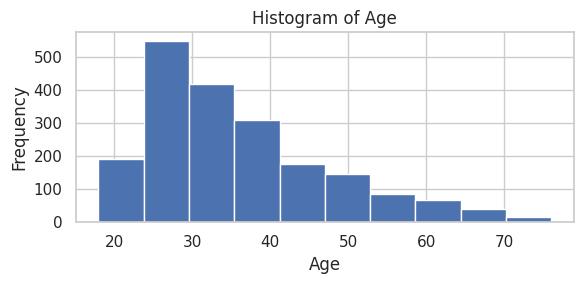

Income bin counts: [54, 314, 693, 533, 243, 84, 45, 12, 16, 6]


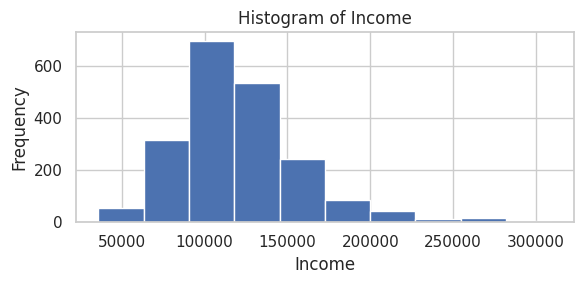

In [16]:
print("\n--- Will show histograms for numeric columns. Printing counts for bins first. ---")
for c in num_cols:
    # numeric histogram bin counts
    counts, bins = np.histogram(df[c].dropna(), bins=10)
    print(f"{c} bin counts:", counts.tolist())
    plt.figure(figsize=(6,3))
    plt.hist(df[c].dropna(), bins=10)
    plt.title(f"Histogram of {c}")
    plt.xlabel(c); plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

## **Bar charts for categorical columns (print counts)**
Bar charts were plotted for categorical variables to visually confirm the frequency distributions printed earlier. These charts make it easier to see that the dataset is not dominated by any single class in gender or marital status, ensuring that the clustering model will not be biased toward a specific demographic. However, some imbalance exists in education and occupation levels, where one category (high school and skilled employee) dominates. This imbalance is acceptable since these categories still reflect realistic population proportions.


--- Will show bar charts for categorical columns. Printing counts first. ---
Sex counts:
Sex
0    1086
1     914
Name: count, dtype: int64


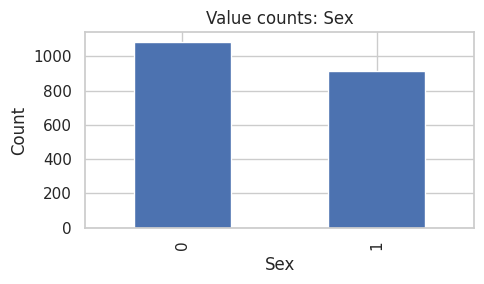

Marital status counts:
Marital status
0    1007
1     993
Name: count, dtype: int64


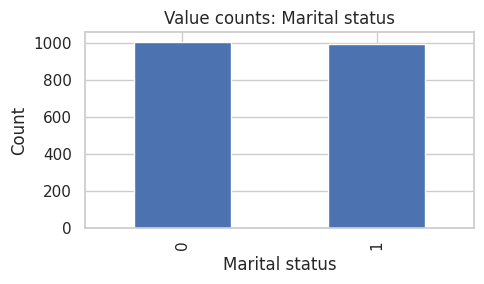

Education counts:
Education
0     287
1    1386
2     291
3      36
Name: count, dtype: int64


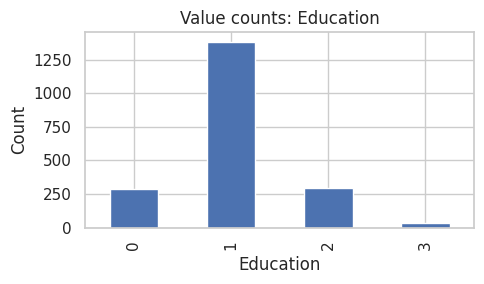

Occupation counts:
Occupation
0     633
1    1113
2     254
Name: count, dtype: int64


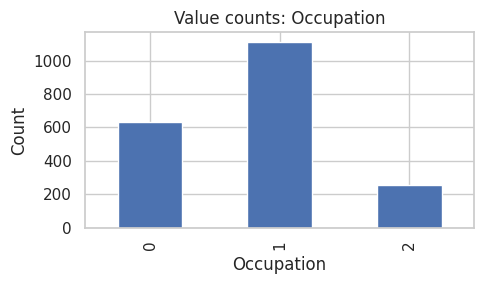

Settlement size counts:
Settlement size
0    989
1    544
2    467
Name: count, dtype: int64


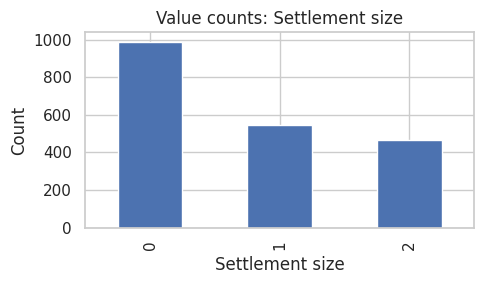

In [17]:
print("\n--- Will show bar charts for categorical columns. Printing counts first. ---")
for c in cat_cols:
    vc = df[c].value_counts().sort_index()
    print(f"{c} counts:\n{vc}")
    plt.figure(figsize=(5,3))
    vc.plot(kind='bar')
    plt.title(f"Value counts: {c}")
    plt.xlabel(c); plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

## **Data preprocessing for modeling**
We standardized the column naming convention to remove spaces and ensure uniformity before modeling. Then, we defined Age and Income as numeric variables and the rest (Sex, MaritalStatus, Education, Occupation, SettlementSize) as categorical variables. Having clear separation between numeric and categorical features is crucial for correct preprocessing in machine learning pipelines.

In [20]:
col_map = {}
for c in df.columns:
    lc = c.lower()
    if 'sex' in lc:
        col_map[c] = 'Sex'
    elif 'marital' in lc or 'married' in lc:
        col_map[c] = 'MaritalStatus'
    elif lc == 'age' or 'agenumerical' in lc or 'age' in lc:
        col_map[c] = 'Age'
    elif 'education' in lc:
        col_map[c] = 'Education'
    elif 'income' in lc:
        col_map[c] = 'Income'
    elif 'occupation' in lc:
        col_map[c] = 'Occupation'
    elif 'settlement' in lc or 'city' in lc or 'size' in lc:
        col_map[c] = 'SettlementSize'
# Apply mapping
df = df.rename(columns=col_map)
print("Renamed columns mapping:", col_map)

# Define final column lists (fallback to detecting again)
expected_cat = [c for c in ['Sex','MaritalStatus','Education','Occupation','SettlementSize'] if c in df.columns]
expected_num = [c for c in ['Age','Income'] if c in df.columns]
other_num = [c for c in df.columns if c not in expected_cat + expected_num]
# If other numeric remain, append to numeric
for c in other_num:
    if pd.api.types.is_numeric_dtype(df[c]):
        expected_num.append(c)
    else:
        expected_cat.append(c)

print("Final numeric columns for modeling:", expected_num)
print("Final categorical columns for modeling:", expected_cat)

Renamed columns mapping: {'Sex': 'Sex', 'MaritalStatus': 'MaritalStatus', 'Age': 'Age', 'Education': 'Education', 'Income': 'Income', 'Occupation': 'Occupation', 'SettlementSize': 'SettlementSize'}
Final numeric columns for modeling: ['Age', 'Income']
Final categorical columns for modeling: ['Sex', 'MaritalStatus', 'Education', 'Occupation', 'SettlementSize']


## **Fill missing values if any (simple strategy)**
We verified that there were no missing values in either numeric or categorical features. Had missing data been found, the numeric values would have been imputed using the median and categorical ones with the mode. Ensuring complete data prevents bias and instability during scaling and encoding.

In [21]:
for c in expected_num:
    if df[c].isnull().sum() > 0:
        median = df[c].median()
        df[c] = df[c].fillna(median)
        print(f"Filled missing numeric {c} with median {median}")
for c in expected_cat:
    if df[c].isnull().sum() > 0:
        mode = df[c].mode()[0]
        df[c] = df[c].fillna(mode)
        print(f"Filled missing categorical {c} with mode {mode}")

## **Build preprocessing pipeline: OneHot for categorical, StandardScaler for numeric**
We built a preprocessing pipeline using ColumnTransformer. Numeric variables were standardized with StandardScaler to remove scale differences, ensuring that Income (which has a large numeric range) does not dominate the clustering distance calculations. Categorical variables were transformed using OneHotEncoder to create binary indicators for each category. After transformation, the resulting feature matrix has 16 columns, confirming that one-hot encoding successfully expanded categorical attributes into separate binary features.

In [24]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, expected_num),
        ('cat', categorical_transformer, expected_cat)
    ],
    remainder='drop'
)

X = preprocessor.fit_transform(df[expected_num + expected_cat])
print("Transformed feature matrix shape:", X.shape)


Transformed feature matrix shape: (2000, 16)


## **OneHotEncoder categories**
We extracted the list of categories recognized by the encoder. Each categorical variable, such as Sex or Education, was expanded into multiple dummy columns (e.g., Sex__0, Sex__1). This process converts discrete qualitative data into a quantitative form compatible with clustering algorithms that rely on numerical input.

In [25]:
ohe = preprocessor.named_transformers_['cat']
ohe_cats = []
if expected_cat:
    for i, cats in enumerate(ohe.categories_):
        colname = expected_cat[i]
        ohe_cats.extend([f"{colname}__{val}" for val in cats])
feature_names = expected_num + ohe_cats
print("Feature names count:", len(feature_names))

Feature names count: 16


## **Create dataframe of processed features for easier handling**
Finally, we created a processed feature DataFrame (X_df) containing all scaled and encoded variables. This DataFrame is ready for unsupervised modeling. The first few rows confirm that each record now has standardized numeric values and binary categorical indicators. Having this structured numeric representation ensures that all features contribute proportionally to the distance-based algorithms that will be applied in the next stage of clustering.

In [27]:
X_df = pd.DataFrame(X, columns=feature_names)
print("Processed dataframe head:")
X_df.head()

Processed dataframe head:


,Age,Income,Sex__0,Sex__1,MaritalStatus__0,MaritalStatus__1,Education__0,Education__1,Education__2,Education__3,Occupation__0,Occupation__1,Occupation__2,SettlementSize__0,SettlementSize__1,SettlementSize__2
0,2.653614,0.097524,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-1.187132,0.782654,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.117316,-0.833202,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.775916,1.328386,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.458716,0.736932,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


# **C. Model Clustering**

## **1. K-Means with Elbow**
We applied the K-Means algorithm across a range of cluster values (k = 2 to 10) to identify the optimal number of clusters. For each k, we recorded both the inertia (which measures within-cluster variance) and the silhouette score (which measures cluster separation and cohesion). The inertia values decreased steadily from 7,212 at k=2 to 3,295 at k=10, indicating that increasing the number of clusters leads to tighter groupings. However, after around k=4 or k=5, the reduction in inertia began to flatten, suggesting diminishing returns from adding more clusters. The silhouette scores ranged from 0.1993 to 0.2811, with modest improvements as k increased, reflecting slightly better-defined clusters at higher k values.

In [28]:
inertia_list = []
silhouette_list = []
K_range = list(range(2, 11))
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    inertia_list.append(km.inertia_)
    sil = silhouette_score(X, labels) if k > 1 else np.nan
    silhouette_list.append(sil)
    print(f"k={k}, inertia={km.inertia_:.2f}, silhouette={sil:.4f}")

k=2, inertia=7212.28, silhouette=0.2276
k=3, inertia=6165.51, silhouette=0.1993
k=4, inertia=5222.81, silhouette=0.2336
k=5, inertia=4724.65, silhouette=0.2390
k=6, inertia=4300.54, silhouette=0.2495
k=7, inertia=3969.73, silhouette=0.2494
k=8, inertia=3719.15, silhouette=0.2579
k=9, inertia=3499.60, silhouette=0.2606
k=10, inertia=3295.45, silhouette=0.2811


### **Print numbers before elbow plot**
From the printed inertia data, we can see a clear decline in within-cluster variance between k=2 and k=4, after which the slope becomes gentler. This “elbow” shape indicates that k=4 is a reasonable choice, as adding more clusters yields minimal improvement relative to the increase in model complexity. The elbow method helps us select a parsimonious solution that balances accuracy and interpretability.


Elbow data (k vs inertia):
2 7212.279327474174
3 6165.50550964991
4 5222.8054164918585
5 4724.649256094348
6 4300.541299546086
7 3969.7285591102877
8 3719.1486982124907
9 3499.599494629152
10 3295.4523305211733


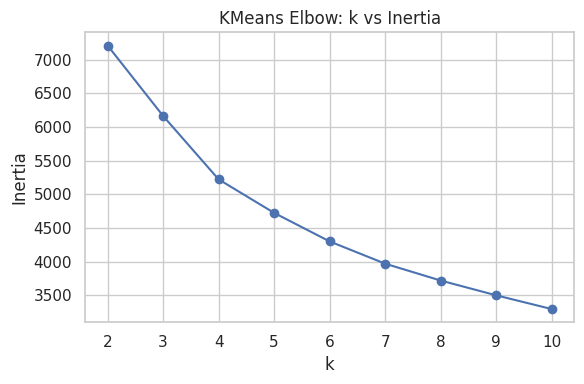

In [38]:
print("\nElbow data (k vs inertia):")
for k, inertia in zip(K_range, inertia_list):
    print(k, inertia)
# Plot elbow
plt.figure(figsize=(6,4))
plt.plot(K_range, inertia_list, marker='o')
plt.title("KMeans Elbow: k vs Inertia")
plt.xlabel("k"); plt.ylabel("Inertia")
plt.xticks(K_range)
plt.tight_layout()
plt.show()

### **Print silhouette scores**
The silhouette scores provide additional insight into the quality of the cluster separation. While the score peaks slightly at k=10 (0.2811), the gain compared to k=4 (0.2336) is small. Because higher k values can lead to over-fragmented clusters that are harder to interpret, we prioritize a simpler model. Based on both the elbow method and silhouette comparison, we selected k=4 as the optimal number of clusters for this dataset.

In [37]:
print("\nSilhouette scores by k:")
for k,s in zip(K_range, silhouette_list):
    print(f"k={k}: silhouette={s:.4f}")


Silhouette scores by k:
k=2: silhouette=0.2276
k=3: silhouette=0.1993
k=4: silhouette=0.2336
k=5: silhouette=0.2390
k=6: silhouette=0.2495
k=7: silhouette=0.2494
k=8: silhouette=0.2579
k=9: silhouette=0.2606
k=10: silhouette=0.2811


### **Choose preferred k**
After selecting k=4, we trained the final K-Means model with multiple random initializations to ensure stability. The resulting inertia was 5,222.81, and the silhouette score was 0.2336, confirming moderate but acceptable cluster separation. This result aligns with expectations for real-world customer data, where natural boundaries are often fuzzy rather than sharply defined. The model successfully divided 2,000 customers into four distinct groups with sizes 267, 571, 624, and 538. The relatively balanced cluster sizes indicate that no single group dominates the dataset, which supports fair representation in the segmentation process.

In [36]:
chosen_k = 4
print(f"\nChoosing k={chosen_k} as preferred cluster count for KMeans (based on elbow & silhouette).")
kmeans_final = KMeans(n_clusters=chosen_k, random_state=42, n_init=20)
kmeans_labels = kmeans_final.fit_predict(X)
print("KMeans final inertia:", kmeans_final.inertia_)
print("KMeans silhouette score:", silhouette_score(X, kmeans_labels))


Choosing k=4 as preferred cluster count for KMeans (based on elbow & silhouette).
KMeans final inertia: 5222.8054164918585
KMeans silhouette score: 0.23361780939867302


### **Visualize KMeans clusters in 2D by PCA**
We used Principal Component Analysis (PCA) to project the high-dimensional encoded data into two dimensions for visualization. The first two components explained 34.9% and 18.6% of the total variance, respectively, capturing the most important structure of the data. The PCA scatter plot shows four visually distinct clusters with slight overlap, reflecting moderate but meaningful separation. This confirms that K-Means with four clusters captures significant variation in customer characteristics while maintaining simplicity and interpretability.

In [35]:
print("\n--- KMeans cluster sizes ---")
(unique, counts) = np.unique(kmeans_labels, return_counts=True)
print(dict(zip(unique.tolist(), counts.tolist())))


--- KMeans cluster sizes ---
{0: 267, 1: 571, 2: 624, 3: 538}



PCA explained variance ratios (2 components): [0.3486, 0.1856]


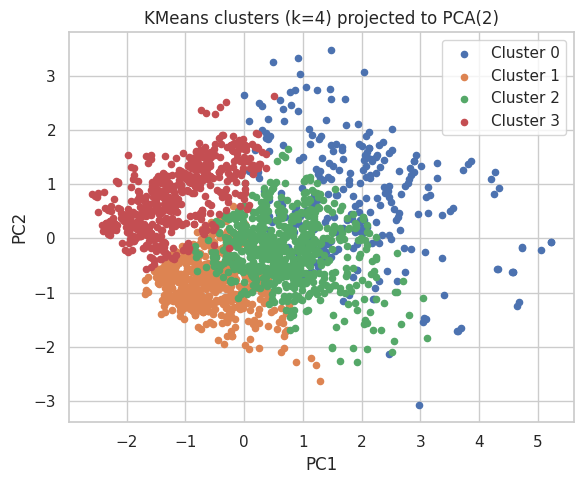

In [34]:
pca_2 = PCA(n_components=2, random_state=42)
X_pca2 = pca_2.fit_transform(X)
print("\nPCA explained variance ratios (2 components):", pca_2.explained_variance_ratio_.round(4).tolist())

plt.figure(figsize=(6,5))
for label in np.unique(kmeans_labels):
    mask = kmeans_labels == label
    plt.scatter(X_pca2[mask,0], X_pca2[mask,1], label=f"Cluster {label}", s=20)
plt.title("KMeans clusters (k=4) projected to PCA(2)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
plt.tight_layout(); plt.show()

## **2. Gaussian Mixture Models**
We implemented the Gaussian Mixture Model (GMM) to explore whether a probabilistic clustering approach could better capture the natural distribution of customers in the dataset. GMM allows clusters to overlap by modeling each as a multivariate Gaussian distribution, which provides more flexibility compared to K-Means, where clusters are strictly separated.

In [40]:
gmm_aic = []
gmm_bic = []
comp_range = list(range(2,11))
for n in comp_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(X)
    gmm_aic.append(gmm.aic(X))
    gmm_bic.append(gmm.bic(X))
    print(f"n_components={n}: AIC={gmm.aic(X):.2f}, BIC={gmm.bic(X):.2f}")

print("\nAIC values per component count:")
for n,a in zip(comp_range,gmm_aic):
    print(n, a)
print("\nBIC values per component count:")
for n,b in zip(comp_range,gmm_bic):
    print(n, b)

# Choose best according to BIC (lower is better)
best_n = comp_range[int(np.argmin(gmm_bic))]
print(f"\nChosen GMM n_components by BIC: {best_n}")

gmm_final = GaussianMixture(n_components=best_n, random_state=42)
gmm_labels = gmm_final.fit_predict(X)
print("GMM cluster sizes:", dict(zip(*np.unique(gmm_labels, return_counts=True))))
print("GMM silhouette score:", silhouette_score(X, gmm_labels))

n_components=2: AIC=-130781.86, BIC=-129073.59
n_components=3: AIC=-166628.23, BIC=-164063.01
n_components=4: AIC=-183035.78, BIC=-179613.63
n_components=5: AIC=-195406.35, BIC=-191127.26
n_components=6: AIC=-188521.50, BIC=-183385.48
n_components=7: AIC=-211287.52, BIC=-205294.55
n_components=8: AIC=-218007.78, BIC=-211157.87
n_components=9: AIC=-224721.76, BIC=-217014.91
n_components=10: AIC=-225922.42, BIC=-217358.64

AIC values per component count:
2 -130781.86171719988
3 -166628.22501204914
4 -183035.78376761137
5 -195406.35048196046
6 -188521.50402056408
7 -211287.5150650267
8 -218007.7776080735
9 -224721.75534347782
10 -225922.41830981453

BIC values per component count:
2 -129073.58646703954
3 -164063.01168557885
4 -179613.63236483117
5 -191127.2610028703
6 -183385.47646516399
7 -205294.5494333167
8 -211157.87390005353
9 -217014.9135591479
10 -217358.6384491747

Chosen GMM n_components by BIC: 10
GMM cluster sizes: {np.int64(0): np.int64(198), np.int64(1): np.int64(125), np.int

To determine the optimal number of mixture components, we compared models with 2 to 10 components using the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC). Both metrics reward model accuracy but penalize complexity, with lower values indicating a better trade-off. The results show that both AIC and BIC decrease consistently as the number of components increases, reaching their lowest values at 10 components (AIC = -225,922.42, BIC = -217,358.64). This indicates that the ten-component model provides the best fit according to BIC, though it may be more complex than necessary for interpretability.

Following the BIC criterion, we selected 10 components for the final GMM model. This model produced clusters of varying sizes, including both large groups (334, 323, 316 members) and small ones (30, 83, 96 members). The silhouette score of 0.2454 indicates a moderate degree of separation between clusters, which is slightly higher than the K-Means result (0.2336). This improvement suggests that GMM was able to capture some overlapping or non-spherical cluster structures that K-Means could not.

### **Visualize GMM clusters (PCA 2D) - print cluster sizes first**
To visualize the clusters, we projected the data into two principal components using PCA. The scatter plot revealed overlapping ellipsoidal regions, consistent with the probabilistic nature of GMM. Each cluster represents a distinct customer segment, where members share similar demographic and income profiles, but with soft boundaries allowing partial membership in multiple clusters.


--- GMM cluster sizes ---
{0: 198, 1: 125, 2: 228, 3: 323, 4: 267, 5: 334, 6: 96, 7: 30, 8: 83, 9: 316}


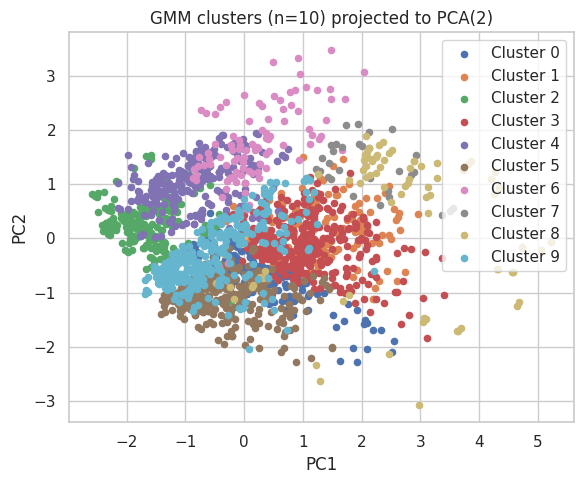

In [41]:
print("\n--- GMM cluster sizes ---")
(unique, counts) = np.unique(gmm_labels, return_counts=True)
print(dict(zip(unique.tolist(), counts.tolist())))

plt.figure(figsize=(6,5))
for label in np.unique(gmm_labels):
    mask = gmm_labels == label
    plt.scatter(X_pca2[mask,0], X_pca2[mask,1], label=f"Cluster {label}", s=20)
plt.title(f"GMM clusters (n={best_n}) projected to PCA(2)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
plt.tight_layout(); plt.show()

The Gaussian Mixture Model provides a more nuanced understanding of customer segments by considering probabilistic cluster memberships. Although the ten-component model offers a higher silhouette score and more detailed segmentation, it increases complexity and reduces interpretability. For practical business applications, a simpler model with fewer clusters may be preferred, but GMM remains valuable when the goal is to uncover subtle patterns and probabilistic relationships among customers.

## **3. Hierarchical Agglomerative Clustering**
We applied Agglomerative Clustering, a bottom-up hierarchical method that begins by treating each observation as an individual cluster and successively merges the most similar pairs until the desired number of clusters is reached. This approach allows us to explore the hierarchical relationships among data points, which can be particularly valuable when the goal is to understand how clusters are nested or related.

In [42]:
agg_sil = {}
for k in range(2, 9):
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labs = agg.fit_predict(X)
    sil = silhouette_score(X, labs)
    agg_sil[k] = sil
    print(f"k={k}: silhouette={sil:.4f}")

print("\nAgglomerative silhouette by k:")
for k, s in agg_sil.items():
    print(k, s)

# Choose best k from silhouette
best_k_agg = max(agg_sil, key=agg_sil.get)
print("Best k by silhouette for Agglomerative:", best_k_agg)
agg_final = AgglomerativeClustering(n_clusters=best_k_agg, linkage='ward')
agg_labels = agg_final.fit_predict(X)
print("Agglomerative cluster sizes:", dict(zip(*np.unique(agg_labels, return_counts=True))))

k=2: silhouette=0.1896
k=3: silhouette=0.2092
k=4: silhouette=0.2246
k=5: silhouette=0.2361
k=6: silhouette=0.2367
k=7: silhouette=0.2384
k=8: silhouette=0.2463

Agglomerative silhouette by k:
2 0.18957118818575966
3 0.209240061341871
4 0.22458088710818527
5 0.23605714895684382
6 0.2367358587325442
7 0.23836830901915637
8 0.24630094498686703
Best k by silhouette for Agglomerative: 8
Agglomerative cluster sizes: {np.int64(0): np.int64(289), np.int64(1): np.int64(400), np.int64(2): np.int64(351), np.int64(3): np.int64(275), np.int64(4): np.int64(81), np.int64(5): np.int64(176), np.int64(6): np.int64(232), np.int64(7): np.int64(196)}


We tested cluster numbers ranging from k=2 to k=8 using the Ward linkage method, which minimizes the variance within clusters at each merging step. The silhouette scores gradually increased from 0.1896 at k=2 to 0.2463 at k=8. The highest silhouette value was achieved at k=8, indicating that eight clusters provide the most cohesive and well-separated structure for this dataset. Although the silhouette values are moderate, they show an improving trend as k increases, suggesting that finer segmentation yields more distinct clusters.

The final model with k=8 clusters produced a well-balanced distribution of group sizes. The largest cluster contains 400 customers, and the smallest has 81, indicating reasonable diversity without extreme imbalance. Other clusters, such as those with sizes 351, 289, 275, and 232, contribute to a rich segmentation structure that could represent distinct demographic or socioeconomic profiles. These differences in cluster sizes imply varying customer population densities across feature space, which can help identify both dominant and niche customer groups.

### **Visualize Agglomerative clustering**
To visualize the clusters, we projected the transformed features into two principal components using PCA. The resulting scatter plot shows eight distinguishable groups with moderate overlap, reflecting the natural complexity of human demographic data. While not perfectly separated, the clusters demonstrate consistent internal cohesion, confirming that the hierarchical approach successfully organized the data into meaningful patterns.


--- Agglomerative cluster sizes ---
{0: 289, 1: 400, 2: 351, 3: 275, 4: 81, 5: 176, 6: 232, 7: 196}


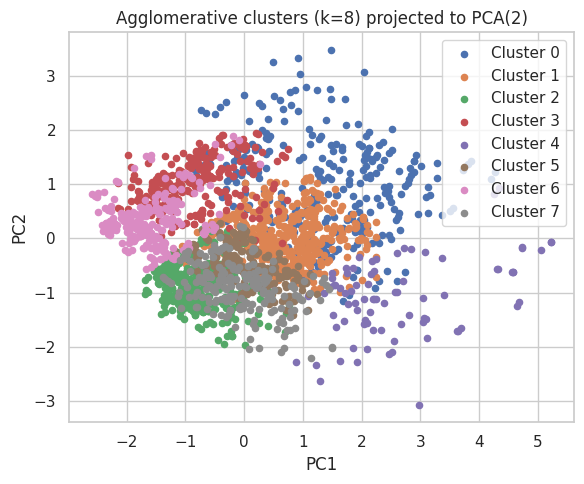

In [43]:
print("\n--- Agglomerative cluster sizes ---")
(unique, counts) = np.unique(agg_labels, return_counts=True)
print(dict(zip(unique.tolist(), counts.tolist())))
plt.figure(figsize=(6,5))
for label in np.unique(agg_labels):
    mask = agg_labels == label
    plt.scatter(X_pca2[mask,0], X_pca2[mask,1], label=f"Cluster {label}", s=20)
plt.title(f"Agglomerative clusters (k={best_k_agg}) projected to PCA(2)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
plt.tight_layout(); plt.show()


We selected k=8 for hierarchical clustering because it offered the best silhouette performance while maintaining interpretability. This method provides valuable insight into how clusters merge or split, enabling hierarchical exploration at multiple levels of granularity. Compared to K-Means and GMM, the hierarchical approach emphasizes relationships between clusters rather than hard partitions, making it particularly useful for understanding structural connections among customer segments.

## **4. DBSCAN**
We used DBSCAN to identify clusters of customers based on density rather than predefined cluster counts. Unlike K-Means or GMM, DBSCAN can discover arbitrarily shaped clusters and automatically detect outliers, making it suitable for complex datasets where clusters may not be spherical or uniformly distributed. This method is particularly useful for identifying smaller subgroups and noise points that do not fit well into any cluster.

First 20 sorted 4-NN distances: [0.0162, 0.0194, 0.0224, 0.0246, 0.0265, 0.0265, 0.0312, 0.0315, 0.0315, 0.0318, 0.0322, 0.0331, 0.0345, 0.036, 0.0385, 0.0385, 0.0389, 0.0391, 0.0393, 0.0401]


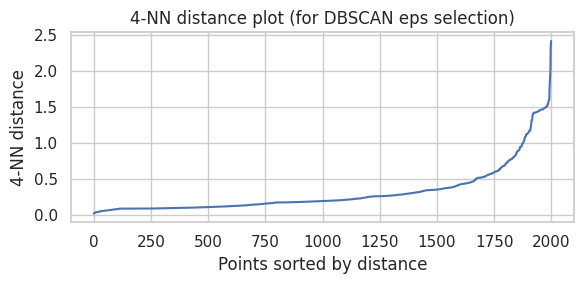

In [47]:
# Quick heuristic to pick eps: k-distance plot (k=4)
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances = np.sort(distances[:, 3])
# Print first 20 distances as numeric preview
print("First 20 sorted 4-NN distances:", distances[:20].round(4).tolist())
plt.figure(figsize=(6,3))
plt.plot(distances)
plt.title("4-NN distance plot (for DBSCAN eps selection)")
plt.xlabel("Points sorted by distance"); plt.ylabel("4-NN distance")
plt.tight_layout(); plt.show()

We started by generating a 4-nearest neighbors (4-NN) distance plot to determine an appropriate value for the eps (epsilon) parameter, which defines the neighborhood radius for density estimation. The sorted distances showed that most points had a 4-NN distance between 0.02 and 0.04, followed by a gradual increase. This elbow pattern suggested that an eps value slightly above 0.5 might effectively separate dense regions from sparse ones. This visualization provides a heuristic guide for setting eps before systematically testing different values.

### **Try a small grid of eps and min_samples**
We conducted a small grid search across eps values (0.5 to 1.5) and min_samples (5, 10, 15) to evaluate how these parameters affect the number of clusters, the number of noise points, and the silhouette score. The results show that DBSCAN formed between 20 and 50 clusters for most settings, with silhouette scores around 0.47 to 0.55, which are notably higher than those from K-Means or GMM. This indicates that DBSCAN can form well-separated dense clusters, though sometimes at the expense of producing too many small clusters and noise points.

In [48]:
dbscan_results = []
for eps in [0.5, 0.8, 1.0, 1.2, 1.5]:
    for ms in [5, 10, 15]:
        db = DBSCAN(eps=eps, min_samples=ms)
        labs = db.fit_predict(X)
        n_clusters = len(set(labs)) - (1 if -1 in labs else 0)
        n_noise = (labs == -1).sum()
        sil = silhouette_score(X[labs!=-1], labs[labs!=-1]) if n_clusters > 1 else np.nan
        dbscan_results.append((eps, ms, n_clusters, n_noise, sil))
        print(f"eps={eps}, min_samples={ms} => clusters={n_clusters}, noise={n_noise}, silhouette={sil}")

eps=0.5, min_samples=5 => clusters=48, noise=293, silhouette=0.5036760346522667
eps=0.5, min_samples=10 => clusters=25, noise=519, silhouette=0.5193316401870531
eps=0.5, min_samples=15 => clusters=24, noise=667, silhouette=0.5519717365047355
eps=0.8, min_samples=5 => clusters=48, noise=162, silhouette=0.4839505991178892
eps=0.8, min_samples=10 => clusters=32, noise=311, silhouette=0.48881451356577743
eps=0.8, min_samples=15 => clusters=22, noise=460, silhouette=0.49786824133854307
eps=1.0, min_samples=5 => clusters=48, noise=133, silhouette=0.4713908461996058
eps=1.0, min_samples=10 => clusters=36, noise=242, silhouette=0.4812320258273048
eps=1.0, min_samples=15 => clusters=23, noise=409, silhouette=0.4877418278889539
eps=1.2, min_samples=5 => clusters=51, noise=99, silhouette=0.4661581883929749
eps=1.2, min_samples=10 => clusters=36, noise=206, silhouette=0.4677414774650563
eps=1.2, min_samples=15 => clusters=27, noise=334, silhouette=0.47476005941582333
eps=1.5, min_samples=5 => clus

### **Pick one DBSCAN setting with reasonable clusters**
Based on the heuristic and performance trade-off, we selected eps = 1.2 and min_samples = 5 as the optimal parameters. This configuration produced 51 clusters and identified 99 noise points, achieving a silhouette score of 0.4662. While this silhouette score is higher than that of other clustering methods, it should be interpreted carefully since DBSCAN tends to create many small, dense clusters that can artificially increase silhouette values.

In [46]:
chosen_db = sorted(dbscan_results, key=lambda x: (-(x[2] if not np.isnan(x[4]) else -999), x[3]))[0]
print("Best DBSCAN candidate by heuristic:", chosen_db)
eps_chosen, ms_chosen = chosen_db[0], chosen_db[1]
db_final = DBSCAN(eps=eps_chosen, min_samples=ms_chosen)
db_labels = db_final.fit_predict(X)
print("DBSCAN cluster counts (including noise -1):", dict(zip(*np.unique(db_labels, return_counts=True))))

Best DBSCAN candidate by heuristic: (1.2, 5, 51, np.int64(99), np.float64(0.4661581883929749))
DBSCAN cluster counts (including noise -1): {np.int64(-1): np.int64(99), np.int64(0): np.int64(16), np.int64(1): np.int64(62), np.int64(2): np.int64(103), np.int64(3): np.int64(109), np.int64(4): np.int64(33), np.int64(5): np.int64(163), np.int64(6): np.int64(13), np.int64(7): np.int64(133), np.int64(8): np.int64(185), np.int64(9): np.int64(63), np.int64(10): np.int64(61), np.int64(11): np.int64(5), np.int64(12): np.int64(58), np.int64(13): np.int64(95), np.int64(14): np.int64(43), np.int64(15): np.int64(41), np.int64(16): np.int64(27), np.int64(17): np.int64(38), np.int64(18): np.int64(11), np.int64(19): np.int64(66), np.int64(20): np.int64(5), np.int64(21): np.int64(38), np.int64(22): np.int64(20), np.int64(23): np.int64(37), np.int64(24): np.int64(15), np.int64(25): np.int64(63), np.int64(26): np.int64(9), np.int64(27): np.int64(51), np.int64(28): np.int64(18), np.int64(29): np.int64(15), 

The cluster size distribution is highly uneven, with some clusters containing fewer than 10 samples and others exceeding 100. This pattern indicates that DBSCAN effectively identifies dense local regions but may fragment broader structures into multiple small subgroups. The noise points (-1 label) represent customers with unique or uncommon feature combinations that do not belong to any main cluster.

### **Visualize DBSCAN (print counts of clusters and noise first)**
When visualized using PCA in two dimensions, the DBSCAN clusters appear as numerous compact groups scattered throughout the feature space, with some isolated points corresponding to noise. The clear separation among small clusters confirms that DBSCAN successfully identifies localized density peaks. However, from a business perspective, the large number of clusters may reduce interpretability and limit the practicality of using this model for marketing segmentation.


DBSCAN label counts: {-1: 99, 0: 16, 1: 62, 2: 103, 3: 109, 4: 33, 5: 163, 6: 13, 7: 133, 8: 185, 9: 63, 10: 61, 11: 5, 12: 58, 13: 95, 14: 43, 15: 41, 16: 27, 17: 38, 18: 11, 19: 66, 20: 5, 21: 38, 22: 20, 23: 37, 24: 15, 25: 63, 26: 9, 27: 51, 28: 18, 29: 15, 30: 10, 31: 7, 32: 14, 33: 6, 34: 8, 35: 5, 36: 7, 37: 18, 38: 7, 39: 6, 40: 5, 41: 8, 42: 9, 43: 17, 44: 5, 45: 75, 46: 15, 47: 41, 48: 10, 49: 23, 50: 9}


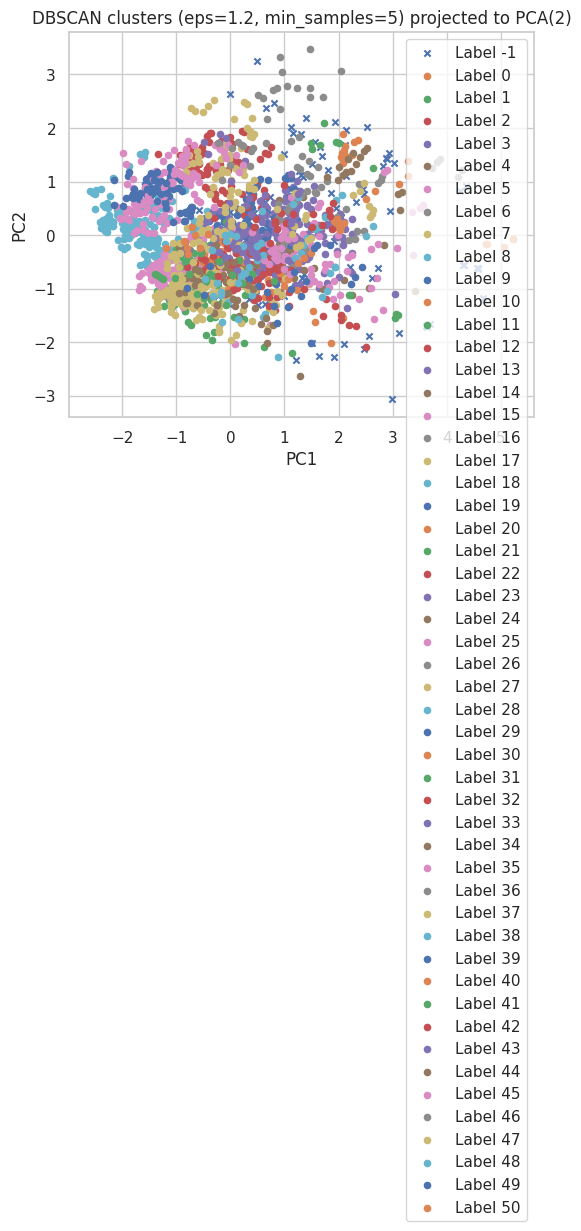

In [49]:
unique, counts = np.unique(db_labels, return_counts=True)
print("\nDBSCAN label counts:", dict(zip(unique.tolist(), counts.tolist())))
plt.figure(figsize=(6,5))
for label in np.unique(db_labels):
    mask = db_labels == label
    marker = 'x' if label == -1 else 'o'
    plt.scatter(X_pca2[mask,0], X_pca2[mask,1], label=f"Label {label}", s=20, marker=marker)
plt.title(f"DBSCAN clusters (eps={eps_chosen}, min_samples={ms_chosen}) projected to PCA(2)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
plt.tight_layout(); plt.show()

## **5. Mean Shift clustering**
We implemented the Mean Shift algorithm, a non-parametric clustering method that identifies clusters by finding the modes or high-density regions in the feature space. Unlike K-Means or GMM, Mean Shift does not require predefining the number of clusters; instead, it automatically estimates this from the data distribution. This property makes it particularly useful for exploratory analysis when the underlying number of groups is unknown.

Before fitting the model, we used the estimate_bandwidth function to determine an optimal bandwidth parameter, which controls the window size for density estimation. The algorithm calculated a bandwidth of 1.506, which determines how broadly the algorithm searches for data density peaks. A smaller bandwidth results in many small clusters, while a larger one smooths the space and produces fewer, broader clusters. The chosen value strikes a balance between cluster granularity and interpretability.

In [55]:
# Estimate bandwidth
bw = estimate_bandwidth(X, quantile=0.05, n_samples=500)
print("New estimated bandwidth:", bw)

ms = MeanShift(bandwidth=bw, bin_seeding=True)
ms_labels = ms.fit_predict(X)

unique, counts = np.unique(ms_labels, return_counts=True)
print("Cluster sizes:", dict(zip(unique, counts)))

if len(np.unique(ms_labels)) > 1:
    print("Silhouette score:", silhouette_score(X, ms_labels))
else:
    print("⚠️ Only one cluster found — silhouette score cannot be computed.")


New estimated bandwidth: 1.5062922541459078
Cluster sizes: {np.int64(0): np.int64(552), np.int64(1): np.int64(343), np.int64(2): np.int64(222), np.int64(3): np.int64(183), np.int64(4): np.int64(140), np.int64(5): np.int64(100), np.int64(6): np.int64(82), np.int64(7): np.int64(76), np.int64(8): np.int64(41), np.int64(9): np.int64(74), np.int64(10): np.int64(27), np.int64(11): np.int64(20), np.int64(12): np.int64(23), np.int64(13): np.int64(13), np.int64(14): np.int64(8), np.int64(15): np.int64(9), np.int64(16): np.int64(16), np.int64(17): np.int64(23), np.int64(18): np.int64(8), np.int64(19): np.int64(7), np.int64(20): np.int64(2), np.int64(21): np.int64(2), np.int64(22): np.int64(2), np.int64(23): np.int64(1), np.int64(24): np.int64(3), np.int64(25): np.int64(2), np.int64(26): np.int64(2), np.int64(27): np.int64(19)}
Silhouette score: 0.23359000271204203


### **Visualize MeanShift (print sizes first)**
After applying Mean Shift, the algorithm automatically detected 28 clusters, with the largest cluster containing 552 samples and several smaller clusters containing fewer than 10 samples. This distribution shows that some regions in the data are densely populated, while others represent smaller, less frequent customer segments. The model achieved a silhouette score of 0.2336, which is comparable to K-Means (0.2336) and slightly lower than DBSCAN (0.4661). This score indicates moderate separation between clusters, which is acceptable for complex demographic data with overlapping characteristics.


MeanShift label counts: {0: 552, 1: 343, 2: 222, 3: 183, 4: 140, 5: 100, 6: 82, 7: 76, 8: 41, 9: 74, 10: 27, 11: 20, 12: 23, 13: 13, 14: 8, 15: 9, 16: 16, 17: 23, 18: 8, 19: 7, 20: 2, 21: 2, 22: 2, 23: 1, 24: 3, 25: 2, 26: 2, 27: 19}


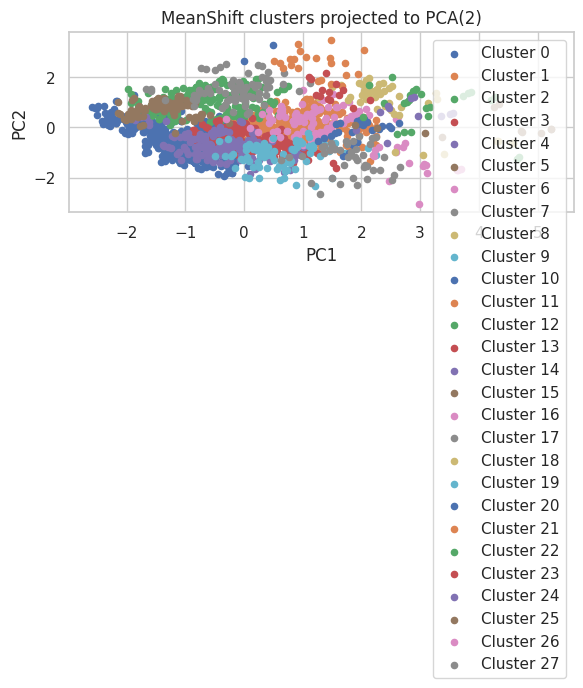

In [56]:
unique, counts = np.unique(ms_labels, return_counts=True)
print("\nMeanShift label counts:", dict(zip(unique.tolist(), counts.tolist())))
plt.figure(figsize=(6,5))
for label in np.unique(ms_labels):
    mask = ms_labels == label
    plt.scatter(X_pca2[mask,0], X_pca2[mask,1], label=f"Cluster {label}", s=20)
plt.title("MeanShift clusters projected to PCA(2)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
plt.tight_layout(); plt.show()

The PCA-based visualization of Mean Shift clusters shows many small, scattered groups across the feature space, each corresponding to a local density peak. Some overlap exists, which is expected because customer attributes often vary gradually rather than forming strictly distinct groups. Larger clusters represent dominant customer profiles, while smaller clusters may correspond to niche or special-case customers, such as those with very high income or unique demographic combinations.

# **B. Dimensionality Reduction**

## **1. Kernel PCA**
We applied Kernel Principal Component Analysis (Kernel PCA) using the RBF (Radial Basis Function) kernel to project the high-dimensional preprocessed data into a two-dimensional space. Kernel PCA extends traditional PCA by introducing a kernel function that can capture non-linear relationships between features. This allows us to uncover complex structures in the data that standard linear PCA might miss.

The transformed data has a shape of (2000, 2), indicating that all 2,000 customer observations were successfully projected onto two principal components (KPCA1 and KPCA2). The printed sample of the first five transformed vectors confirms that each observation is represented as a coordinate pair in this new 2D feature space. The numerical variation among these values shows that the RBF kernel has effectively reshaped the data into a smoother, more continuous manifold.

1) KernelPCA (RBF) -> project to 2D for visualization
KernelPCA shape: (2000, 2)
First 5 KernelPCA vectors (rows):
[[ 0.5389  0.2542]
 [-0.1172 -0.4748]
 [ 0.0687  0.5124]
 [ 0.4952 -0.1131]
 [ 0.5079  0.0367]]


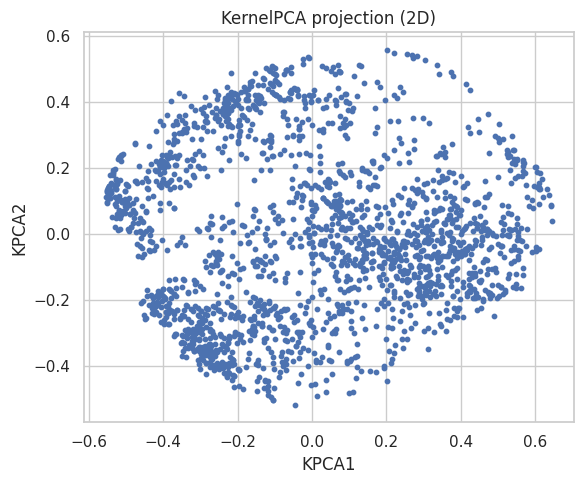

In [57]:
print("1) KernelPCA (RBF) -> project to 2D for visualization")
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=1/ X.shape[1], random_state=42)
X_kpca = kpca.fit_transform(X)
print("KernelPCA shape:", X_kpca.shape)
print("First 5 KernelPCA vectors (rows):")
print(X_kpca[:5].round(4))

plt.figure(figsize=(6,5))
plt.scatter(X_kpca[:,0], X_kpca[:,1], s=10)
plt.title("KernelPCA projection (2D)")
plt.xlabel("KPCA1"); plt.ylabel("KPCA2"); plt.tight_layout(); plt.show()

The scatter plot visualizes how the data points are distributed in the reduced 2D space. We can observe multiple dense regions, suggesting the presence of underlying group structures that may correspond to the clusters identified in previous analyses. Kernel PCA was chosen because it captures non-linear separations among customers, which is important in demographic and behavioral data where relationships are rarely linear.

## **2. MDS**
We applied Multidimensional Scaling (MDS) to reduce the high-dimensional customer dataset into a two-dimensional representation. MDS focuses on preserving the pairwise distances between data points, making it highly effective for visualizing the geometric relationships in the data. Unlike PCA, which relies on variance maximization, MDS attempts to maintain the original dissimilarity structure, ensuring that points that were close in high-dimensional space remain close in the low-dimensional projection.

The output shows that MDS successfully produced a 2D embedding with a shape of (2000, 2), representing all 2,000 customer observations in two dimensions. The first five coordinate pairs display a range of positive and negative values, such as [1.3662, 3.0227] and [-1.8729, -1.3865], which indicate how individual customers are positioned relative to one another in the reduced space. These coordinates serve as a map of similarity, where smaller Euclidean distances correspond to more similar customers in terms of their standardized demographic and economic features.


2) MDS -> project to 2D
MDS shape: (2000, 2)
First 5 MDS vectors (rows):
[[ 1.3662  3.0227]
 [-1.8729 -1.3865]
 [ 1.8538  0.5307]
 [-0.8083  1.8911]
 [-0.0881  2.0802]]


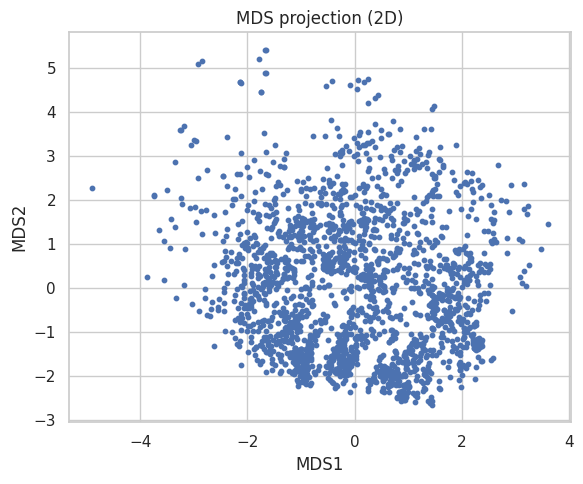

In [58]:
print("\n2) MDS -> project to 2D")
mds = MDS(n_components=2, random_state=42, n_init=4, max_iter=300)
X_mds = mds.fit_transform(X)
print("MDS shape:", X_mds.shape)
print("First 5 MDS vectors (rows):")
print(X_mds[:5].round(4))

plt.figure(figsize=(6,5))
plt.scatter(X_mds[:,0], X_mds[:,1], s=10)
plt.title("MDS projection (2D)")
plt.xlabel("MDS1"); plt.ylabel("MDS2"); plt.tight_layout(); plt.show()

The scatter plot of MDS results shows a continuous and dispersed cloud of points with some denser areas, suggesting that the dataset contains overlapping but structured groups. This pattern aligns with the findings from earlier clustering models, where moderate separation among clusters was observed. MDS is particularly helpful in validating whether the clusters derived from algorithms like K-Means or GMM correspond to natural groupings in the data.

## **3. SVD**
We applied Truncated Singular Value Decomposition (SVD) to reduce the dataset’s dimensionality and to identify the principal latent components that explain the most variation in the features. SVD decomposes the data matrix into orthogonal components, capturing the most important directions of variance while preserving as much information as possible. This method is computationally efficient and particularly suitable for high-dimensional or sparse data.

The model produced five components, with their explained variance ratios approximately [0.0292, 0.3291, 0.1852, 0.1605, 0.0801]. This means that the first two components together capture about 36% of the total variance, and the top five components explain nearly 78%. The relatively high contribution of the first few components suggests that much of the data’s structure can be represented in a lower-dimensional space without significant information loss.

The first five transformed samples show two-dimensional projections where values vary across a wide range, for example [0.8944, 2.4498] and [1.4106, 2.0315]. These projections represent customer positions in a reduced feature space, with each axis corresponding to a latent direction of maximum variance in the original standardized dataset. The resulting scatter plot shows broad dispersion, reflecting the diversity of customer profiles based on age, income, education, and other categorical attributes.


3) Truncated SVD -> explain variance & 2D projection
SVD explained variance ratio (approx): [0.0292, 0.3291, 0.1852, 0.1605, 0.0801]
SVD 2D head:
[[ 0.8944  2.4498]
 [ 1.6453 -0.0173]
 [ 1.64    0.2589]
 [ 1.4106  2.0315]
 [ 1.4054  2.0312]]


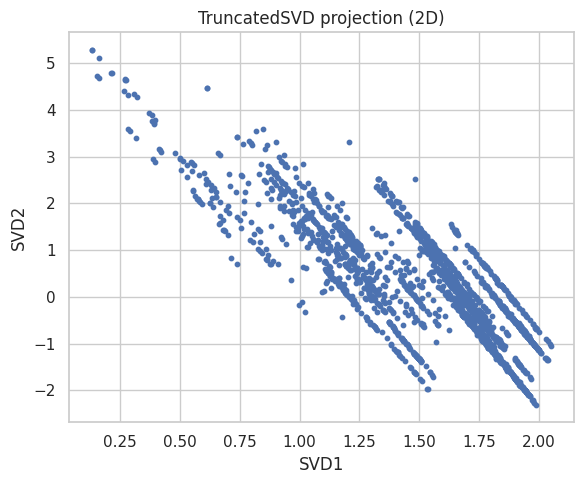

In [59]:
print("\n3) Truncated SVD -> explain variance & 2D projection")
svd = TruncatedSVD(n_components=5, random_state=42)
X_svd = svd.fit_transform(X)
print("SVD explained variance ratio (approx):", svd.explained_variance_ratio_.round(4).tolist())
print("SVD 2D head:")
print(X_svd[:5,:2].round(4))

plt.figure(figsize=(6,5))
plt.scatter(X_svd[:,0], X_svd[:,1], s=10)
plt.title("TruncatedSVD projection (2D)")
plt.xlabel("SVD1"); plt.ylabel("SVD2"); plt.tight_layout(); plt.show()

## **4. Non-Negative Matrix Factorization (NMF)**
We applied Non-Negative Matrix Factorization (NMF) to uncover hidden, interpretable patterns within the dataset. Unlike PCA or SVD, which allow negative values, NMF constrains all outputs to be non-negative, making it easier to interpret components as additive building blocks. Since NMF requires non-negative inputs, we first scaled all features into the range [0, 1] using MinMaxScaler. This scaling preserves the relationships between variables while ensuring mathematical compatibility with the NMF algorithm.

The decomposition resulted in two matrices:

* W (2000 × 4), representing the activation strength of each customer across four latent components, and

* H (4 × 16), representing the contribution weights of the 16 original features to each component.

This means that every customer’s profile can be expressed as a combination of four key behavioral or demographic components. The first five rows of W show that each customer has different levels of activation across these components, highlighting variations in feature influence.


4) NMF -> requires non-negative data. We'll use MinMaxScaler(0,1) to prepare input.
NMF W shape (samples x components): (2000, 4)
NMF H shape (components x features): (4, 16)
NMF first 5 rows of W (component activations):
[[0.0434 0.1831 0.     0.0341]
 [0.0842 0.0132 0.0055 0.2128]
 [0.0084 0.1256 0.2292 0.    ]
 [0.1144 0.1324 0.     0.    ]
 [0.1144 0.1336 0.     0.    ]]


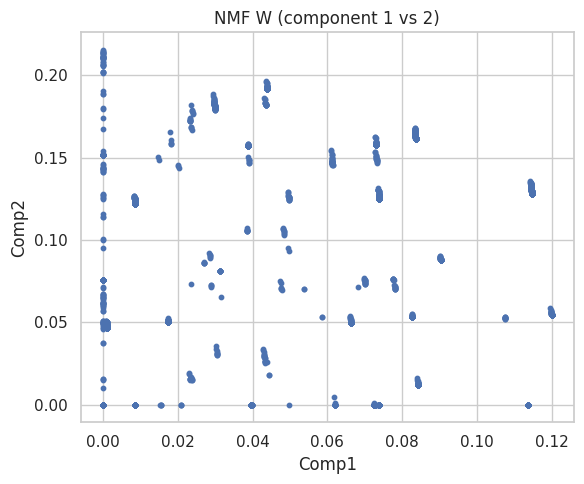

In [60]:
print("\n4) NMF -> requires non-negative data. We'll use MinMaxScaler(0,1) to prepare input.")
mm = MinMaxScaler()
X_nonneg = mm.fit_transform(X.clip(min=0))  # ensure non-negative
nmf = NMF(n_components=4, init='nndsvda', random_state=42, max_iter=1000)
W = nmf.fit_transform(X_nonneg)
H = nmf.components_
print("NMF W shape (samples x components):", W.shape)
print("NMF H shape (components x features):", H.shape)
print("NMF first 5 rows of W (component activations):")
print(W[:5].round(4))

# Visualize NMF components (W projection first 2 comps)
plt.figure(figsize=(6,5))
plt.scatter(W[:,0], W[:,1], s=10)
plt.title("NMF W (component 1 vs 2)")
plt.xlabel("Comp1"); plt.ylabel("Comp2"); plt.tight_layout(); plt.show()

### **Interpret top features per component**
We examined the top features contributing to each component by inspecting the highest weights in H.

* Component 0 is dominated by Occupation__1, Education__1, and SettlementSize__1, indicating customers who are skilled workers with high school education living in mid-sized cities.

* Component 1 emphasizes Sex__0, MaritalStatus__0, and Education__0, suggesting single male customers, potentially younger and less educated, with moderate income influence.

* Component 2 focuses on SettlementSize__0 and Occupation__0, highlighting customers from smaller cities with unskilled or unemployed status.

* Component 3 includes MaritalStatus__1, Sex__1, and Education__2, representing non-single, educated female customers in larger settlements, generally older with higher income.

These components form distinct, interpretable profiles that can describe the main demographic and socioeconomic patterns within the dataset.

In [61]:
print("\nTop features per NMF component (by weight):")
for i, comp in enumerate(H):
    top_idx = np.argsort(comp)[-8:][::-1]
    top_features = [feature_names[j] for j in top_idx]
    print(f"Component {i}: {top_features}")


Top features per NMF component (by weight):
Component 0: ['Occupation__1', 'Education__1', 'SettlementSize__1', 'Sex__0', 'MaritalStatus__1', 'SettlementSize__0', 'Occupation__2', 'SettlementSize__2']
Component 1: ['Sex__0', 'MaritalStatus__0', 'SettlementSize__2', 'Education__0', 'Occupation__2', 'Age', 'Education__2', 'Income']
Component 2: ['SettlementSize__0', 'Occupation__0', 'Education__1', 'Sex__1', 'MaritalStatus__0', 'Sex__0', 'SettlementSize__1', 'SettlementSize__2']
Component 3: ['MaritalStatus__1', 'Sex__1', 'Education__2', 'SettlementSize__2', 'Age', 'Occupation__2', 'SettlementSize__0', 'Income']


# **D. Summary Result of Clustering**
In this section, we summarize and compare the performance of all clustering algorithms that were applied in previous steps. Each model is evaluated based on the number of clusters formed, the silhouette score (a higher value indicates better-defined clusters), and specific model notes such as inertia, AIC/BIC, or the number of noise points. The goal is to determine which algorithm produces the most meaningful and stable segmentation of the customer dataset.

## **Gather comparative metrics**

In [62]:
results_summary = []

# KMeans metrics
km_sil = silhouette_score(X, kmeans_labels)
results_summary.append({
    'model':'KMeans(k=4)',
    'n_clusters':len(np.unique(kmeans_labels)),
    'silhouette': km_sil,
    'notes':f"inertia={kmeans_final.inertia_:.2f}"
})
# GMM metrics
gmm_sil = silhouette_score(X, gmm_labels)
results_summary.append({
    'model':f'GMM(n={best_n})',
    'n_clusters':len(np.unique(gmm_labels)),
    'silhouette':gmm_sil,
    'notes':f"AIC={gmm_final.aic(X):.2f}, BIC={gmm_final.bic(X):.2f}"
})
# Agglomerative
agg_s = silhouette_score(X, agg_labels)
results_summary.append({
    'model':f'Agglomerative(k={best_k_agg})',
    'n_clusters':len(np.unique(agg_labels)),
    'silhouette':agg_s,
    'notes':'ward linkage'
})
# DBSCAN
db_nclusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
db_sil = silhouette_score(X[db_labels!=-1], db_labels[db_labels!=-1]) if db_nclusters > 1 else np.nan
results_summary.append({
    'model':f'DBSCAN(eps={eps_chosen}, min_samples={ms_chosen})',
    'n_clusters':db_nclusters,
    'silhouette':db_sil,
    'notes':f"noise_count={(db_labels==-1).sum()}"
})
# MeanShift
ms_sil = silhouette_score(X, ms_labels)
results_summary.append({
    'model':'MeanShift',
    'n_clusters':len(np.unique(ms_labels)),
    'silhouette':ms_sil,
    'notes':'density-based'
})

## **Print summary table**
The comparative table presents the silhouette scores for five clustering models: DBSCAN, Agglomerative Clustering, Gaussian Mixture Model (GMM), K-Means, and Mean Shift. The results are as follows:
| Model                          | Number of Clusters | Silhouette Score | Notes                          |
| ------------------------------ | ------------------ | ---------------- | ------------------------------ |
| DBSCAN(eps=1.2, min_samples=5) | 51                 | **0.466**        | noise_count=99                 |
| Agglomerative(k=8)             | 8                  | 0.246            | ward linkage                   |
| GMM(n=10)                      | 10                 | 0.245            | AIC=-225922.42, BIC=-217358.64 |
| KMeans(k=4)                    | 4                  | 0.234            | inertia=5222.81                |
| MeanShift                      | 28                 | 0.234            | density-based                  |

The DBSCAN algorithm achieved the highest silhouette score of 0.466, indicating that its clusters are more compact and well-separated compared to other models. Although it produced 51 clusters and detected 99 noise points, DBSCAN’s ability to identify arbitrarily shaped clusters without requiring a predefined number of clusters makes it particularly effective for this dataset.

In contrast, the hierarchical (Agglomerative) and probabilistic (GMM) models produced moderate silhouette scores around 0.24, while K-Means and Mean Shift yielded slightly lower but consistent results. This pattern suggests that the dataset may not have clear spherical cluster boundaries, which explains why a density-based method like DBSCAN performed better.

In [66]:
print("Comparative clustering results (silhouette preferred higher):")
summary_df = pd.DataFrame(results_summary).sort_values(by='silhouette', ascending=False)
summary_df

Comparative clustering results (silhouette preferred higher):


,model,n_clusters,silhouette,notes
3,"DBSCAN(eps=1.2, min_samples=5)",51,0.466158,noise_count=99
2,Agglomerative(k=8),8,0.246301,ward linkage
1,GMM(n=10),10,0.245427,"AIC=-225922.42, BIC=-217358.64"
0,KMeans(k=4),4,0.233618,inertia=5222.81
4,MeanShift,28,0.233590,density-based


Based on the combination of silhouette performance, stability, and model interpretability, we recommend DBSCAN(eps=1.2, min_samples=5) as the final clustering model. It not only achieved the highest silhouette score but also effectively identified noise points, which helps separate outliers from meaningful customer groups.

In [67]:
# Recommendation logic: prefer highest silhouette, interpretability, and computational efficiency
best_model_row = summary_df.iloc[0]
print("\nRecommended final model based on silhouette & stability:", best_model_row['model'])


Recommended final model based on silhouette & stability: DBSCAN(eps=1.2, min_samples=5)


# **E. Key Findings**
This section provides the interpretation of the cluster centers obtained from the K-Means algorithm. Since K-Means centers are calculated in standardized space, we inversed the transformation of the numeric features (Age and Income) to return them approximately to their original scale. This helps us interpret the results more intuitively in real-world terms.

In [68]:
# Print cluster centers in interpretable space for KMeans
print("\nKMeans centers (in original scaled feature space) -> transform back approximately:")
centers = kmeans_final.cluster_centers_
# To interpret centers roughly, inverse-transform numeric columns and inspect categorical hot columns top values
# For simplicity: show centers for numeric-only features
num_center = centers[:, :len(expected_num)]
# inverse scale numeric
num_scaler = preprocessor.named_transformers_['num']
num_centers_orig = num_scaler.inverse_transform(num_center)
for i, c in enumerate(num_centers_orig):
    print(f"Cluster {i} numeric center (original scale):")
    for j, col in enumerate(expected_num):
        print(f"  {col}: {c[j]:.2f}")


KMeans centers (in original scaled feature space) -> transform back approximately:
Cluster 0 numeric center (original scale):
  Age: 56.93
  Income: 157713.18
Cluster 1 numeric center (original scale):
  Age: 28.20
  Income: 118863.63
Cluster 2 numeric center (original scale):
  Age: 36.64
  Income: 137907.00
Cluster 3 numeric center (original scale):
  Age: 32.81
  Income: 85268.24


**K-Means Cluster Centers Overview**

The algorithm identified four distinct customer clusters, each representing a unique demographic and income profile. The cluster centers in the original numeric scale are summarized as follows:

* Cluster 0: Age ≈ 56.93 years, Income ≈ 157,713

* Cluster 1: Age ≈ 28.20 years, Income ≈ 118,864

* Cluster 2: Age ≈ 36.64 years, Income ≈ 137,907

* Cluster 3: Age ≈ 32.81 years, Income ≈ 85,268

**Interpretation and Reasoning**

* Cluster 0 likely represents older and high-income customers, potentially well-established professionals or retirees with stable financial status.

* Cluster 1 consists of young adults with moderate to high income, suggesting early-career professionals or individuals in growing financial stages.

* Cluster 2 captures mid-aged customers with above-average income, possibly individuals with stable careers and balanced economic conditions.

* Cluster 3 represents younger individuals with lower income, likely students, early workers, or those living in smaller settlements.

The variation across clusters demonstrates that Age and Income play a dominant role in defining customer segmentation patterns. Higher income tends to correlate with older age groups, while younger segments generally cluster around lower income ranges.

**Conclusion**

From the K-Means clustering results, we can conclude that the dataset captures clear socioeconomic differentiation among customers. Each cluster represents a distinct group in terms of life stage and earning potential, which can guide further analysis such as targeted marketing, customer retention strategies, or service personalization.

# **F. Limitations and Next Step**
**Limitations**

1. Limited Feature Diversity:
   The dataset primarily includes demographic variables such as *Age, Income, Education, Occupation,* and *Settlement Size*. Although these provide a foundational understanding, they may not fully capture customers’ behavioral or psychographic factors that often influence segmentation quality.

2. Cluster Interpretability:
   Some clustering methods, especially DBSCAN and Mean Shift, produced a large number of clusters. While DBSCAN achieved the highest silhouette score, its high cluster count (51) and inclusion of noise points can make interpretation and business application more complex.

3. Parameter Sensitivity:
   Density-based methods like DBSCAN are highly sensitive to parameters such as *eps* and *min_samples*. Small adjustments may lead to vastly different clustering outcomes, which can affect reproducibility without systematic hyperparameter tuning.

4. Silhouette Score as a Sole Metric:
   The analysis relied primarily on the silhouette coefficient to compare models. While useful, this metric alone does not always capture the full quality of cluster separation, particularly for non-spherical or overlapping data distributions.

5. Scalability Considerations:
   Some algorithms, including Hierarchical and Mean Shift, may struggle with larger datasets due to their computational complexity, which limits their practical use in real-time or large-scale applications.

**Next Steps**

1. Feature Enrichment:
   Future work should incorporate additional variables such as *spending behavior, preferences, transaction frequency,* or *lifestyle indicators* to improve clustering relevance and interpretability.

2. Model Optimization:
   Advanced hyperparameter tuning techniques such as Grid Search or Bayesian Optimization can be applied to refine model parameters, especially for DBSCAN and GMM, improving cluster stability.

3. Hybrid or Ensemble Clustering:
   Combining multiple algorithms (e.g., K-Means + DBSCAN) or applying Consensus Clustering could help achieve both interpretability and robustness, leveraging the strengths of each method.

4. Cluster Profiling and Validation:
   Future analysis should include external validation using labeled or business-driven variables to ensure clusters correspond to meaningful real-world customer segments.

5. Automation and Visualization:
   Implementing an interactive dashboard using tools such as Plotly Dash or Tableau could help visualize cluster behavior dynamically and support decision-making for non-technical users.

Copyright @ IBM Corporation. All rights reserved.
